<img src="img/sztaki.png">

# <p style="text-align: center;">A simple image classifier for testing our virtual environment</p>

<img src="img/cnn.jpg">

<p style="text-align: justify;">In this short demo application we can test our Anaconda development environment. We are building a convolutional neural network (__CNN__ or __ConvNet__) which is able to classify animals into 4 categories (dog, cat, bird and fish). Classification is a type of supervised learning - this means we need to provide labels for all the training data. We are going to utilize __Keras__ with __Tensorflow backend__ for achieving this goal, more precisely for creating and compiling model, training and testing. Keras enables fast experimentation with deep neural networks, and it focuses on being user-friendly and modular, so it's a natural choice for this task, while Tensorflow is responsible for managing the underlying structures and calculations.</p>

#### Modules for preprocessing:

In [1]:
from PIL import Image
import cv2

#### Other required libraries: 

In [2]:
import numpy as np
import os
import datetime
import IPython.display

#### First we set the names of directories and files required. If you wish to use your own, make sure to locate them in project root. 

In [3]:
raw_data_directory = 'raw_data'
preprocessed_data_directory = 'preprocessed_training_data'
test_directory = 'test_data'
persisted_model_directory = 'saved_models'
creation_time = ''

animals_filename = f'./{preprocessed_data_directory}/animals{creation_time}.npy'
labels_filename = f'./{preprocessed_data_directory}/labels{creation_time}.npy'

#### We would like to teach our CNN to distinguish between the categories listed below:

In [4]:
data_path = f'./{raw_data_directory}/'
categories = os.listdir(data_path) 
print('Categories: ', categories)

Categories:  ['bird', 'cat', 'dog', 'fish']


## Step 0 – Preprocessing (_optional_)

#### <p style="text-align: justify;">NOTE: In this example no preprocessing is neccessary as the already preprocessed, ready-to-use image data can be found in directory `./preprocessed_training_data` .</p>

<p style="text-align: justify;">We have to resize and convert our data first. The first one is needed because training images come in different sizes, however, neural networks accept inputs in the dimension, the latter is to map our image data into arrays of numbers. The explanation can be found on following illustration:</p> 

<img src="img/img_to_array.png">

#### So let's start data transformation! 

#### We begin with defining a function that transforms a single image.

In [5]:
def preprocess_img(img_name, shape=(50,50)):
    img = cv2.imread(img_name)
    img_from_ar = Image.fromarray(img, 'RGB')
    resized_image = img_from_ar.resize(shape)
    return np.array(resized_image).astype('float32')/255

#### <p style="text-align: justify;">Then we create another function that preprocesses all training data and also collects the corresponding labels.</p>

In [6]:
def preprocess_images(categories):
    data, labels = [], []
    
    for category in categories: 
        current_dir_name = data_path+category
        images = os.listdir(current_dir_name)
        for img_name in images:
            if not img_name.startswith('.'): #Jupyter notebooks create hidden checkpoints, so we have to ignore them (they start with a '.')
                img = preprocess_img(f'{current_dir_name}/{img_name}')
                data.append(img)
                labels.append(categories.index(category))
    return np.array(data), np.array(labels)

#### Now preprocess training data and their labels, too:

In [7]:
data, labels = preprocess_images(categories)

### We successfully transformed our data, let's persist them so that we can omit preprocessing next time.


In [8]:
creation_time = datetime.datetime.now()

#### Name our files...

In [9]:
animals_filename = f'./{preprocessed_data_directory}/animals{creation_time}.npy'
labels_filename = f'./{preprocessed_data_directory}/labels{creation_time}.npy'

#### ...and save them.

In [10]:
np.save(animals_filename, np.array(data))
np.save(labels_filename, np.array(labels))

## Step 1 – Prepare data for training

### If you skipped Step 1, you can start from here, otherwise the following operation can be left out. 

#### Load data:

In [11]:
animals = np.load(animals_filename)
labels = np.load(labels_filename)

<p style="text-align: justify;">We have to shuffle our dataset. It's a crucial step to because the images are sorted in a specified order.  If we select data for training and test without considering this, we will select each class for different tasks, and it will fail the process.

 Fix random seed for reproducability (our CNN also relies on `np.random`, so it's going to be useful later, too):</p> 

In [12]:
np.random.seed(42)

#### Perform shuffling:

In [13]:
s = np.arange(animals.shape[0])
np.random.shuffle(s)

animals = animals[s]
labels = labels[s]

### Split shuffled data into training and test data and convert them. In this example, we use 70% for training and 30% for testing. 

In [14]:
test_percent = 20

In [15]:
data_length = len(animals)

(X_train, X_test) = animals[(int)((test_percent/100)*data_length):], animals[:(int)((test_percent/100)*data_length)]
(y_train, y_test) = labels[(int)((test_percent/100)*data_length):], labels[:(int)((test_percent/100)*data_length)]

#### Let's so how many training and test data we have:

In [16]:
training_data_size = len(X_train)
test_data_size = len(X_test)

print('Training data size:', training_data_size)
print('Test data size:', test_data_size)

Training data size: 1587
Test data size: 396


<p style="text-align: justify;">Unfortunately, we cannot work directly with categorical data. So, we must somehow convert our input data to numbers, then only our GPU be able to process the data. Once we are done with the processing on the numbers, we need another mechanism to somehow revert the output to the same format as that of the input data. We use one-hot-encoding that works the way represented below:</p>

<img src="img/one-hot.jpg">

#### Import Keras to perform one-hot-encoding in just one line of code.

In [17]:
import keras
from keras.utils import np_utils

class_number = len(np.unique(labels))

y_train = keras.utils.to_categorical(y_train, class_number)
y_test = keras.utils.to_categorical(y_test, class_number)

Using TensorFlow backend.


## Step 3 – Create and compile model

<p style="text-align: justify;">We use sequential model, and for building our ConvNet we need various types of layer, each one for different kind of operations. If we run the next cell, we will see a summary of the structure of the network in the end.</p>

<img src="img/cnn_layers.png">

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxP

#### Now that we have built our network, specify the method for used for training (the 'optimizer' here) as well as the loss function and the metrics.

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

#### Set the number of epochs which is equal to the number of iterations on the whole dataset.

In [20]:
epochs = 80

## Step 4  – Training

Our model is ready for training now, so let's fit it.

In [21]:
model.fit(X_train, y_train, batch_size=50, epochs=epochs, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/80
1587/1587 [==============================] - 7s 5ms/step - loss: 1.3438 - acc: 0.3617
Epoch 2/80
1587/1587 [==============================] - 0s 280us/step - loss: 1.1803 - acc: 0.4638
Epoch 3/80
1587/1587 [==============================] - 0s 272us/step - loss: 1.0273 - acc: 0.5608
Epoch 4/80
1587/1587 [==============================] - 0s 264us/step - loss: 0.9557 - acc: 0.5942
Epoch 5/80
1587/1587 [==============================] - 0s 268us/step - loss: 0.8388 - acc: 0.6698
Epoch 6/80
1587/1587 [==============================] - 0s 254us/step - loss: 0.8000 - acc: 0.6843
Epoch 7/80
1587/1587 [==============================] - 0s 242us/step - loss: 0.7226 - acc: 0.7265
Epoch 8/80
1587/1587 [==============================] - 0s 242us/step - loss: 0.6719 - acc: 0.7486
Epoch 9/80
1587/1587 [==============================] - 0s 256us/step - loss: 0.5872 - acc: 0.7763
Epoch 10/80
1587/1587 [==============================] - 0s 249

Epoch 80/80
1587/1587 [==============================] - 0s 249us/step - loss: 0.0138 - acc: 0.9968


#### Evaluate model:

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', score[1])

396/396 [==============================] - 0s 578us/step
Test accuracy: 0.6717171723192389


Here we can see that our __model accuracy is about 66%__, in other words it makes the right decision in two third of the cases. Apparently, it's not the best but still somewhat accurate. 

## Step 5  – Testing

<p style="text-align: justify;">Now let's start testing. Earlier, we converted image data to matrices, collected and shuffled them, all we have now in array `X_test` is sequences of numbers randomized. Of course, we could apply them for testing, but the interpretation of the results provided by these "pictures" would be difficult. Ordinary images are more meaningful for our human eyes, so we will use some loaded from another folder specified above in variable `test_directory`.</p>

In [23]:
def preprocess_img(img_name, shape=(50,50)):
    img = cv2.imread(img_name)
    img_from_ar = Image.fromarray(img, 'RGB')
    resized_image = img_from_ar.resize(shape)
    return np.array(resized_image).astype('float32')/255

#### We are defining a function that makes a prediction with a single image and returns the name of the corresponding animal.

In [24]:
def get_animal_name(label_number):
    return categories[label_number]

In [25]:
def predict_animal(test_image_file):
    print('Predicting... ...')   
    test_image = preprocess_img(test_image_file)
    predictions = model.predict(np.expand_dims(test_image, axis=0), verbose=1)
    predicted_animal = get_animal_name(np.argmax(predictions))
    print(f'Predicted animal: {predicted_animal}, probability: {np.amax(predictions)}')
    return predicted_animal

#### First, let's test it with for example this cat image:

In [26]:
test_image = f'./{test_directory}/cat.jpeg'

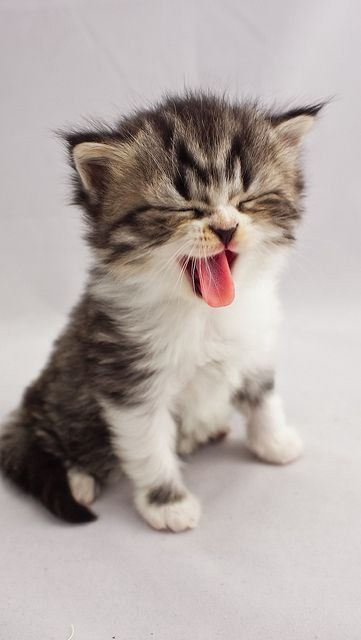

In [27]:
IPython.display.Image(test_image)

#### Find out the result:

In [28]:
predict_animal(test_image)

Predicting... ...
1/1 [==============================] - 0s 82ms/step
Predicted animal: cat, probability: 0.9999370574951172


'cat'

#### Now let's see it with multiple images at once.

In [29]:
def predict_animals(test_image_files):
    for test_image_file in test_image_files:
        print(test_image_file)
        predicted = predict_animal(test_image_file)
        result = 'RIGHT' if predicted in test_image_file else 'WRONG'
        print(f'{result} guess.\n')

In [30]:
test_image_files = os.listdir(f'./{test_directory}')
test_image_list = [f'./{test_directory}/{img}' for img in test_image_files]

In [31]:
predict_animals(test_image_list)

./test_data/dog.jpg
Predicting... ...
1/1 [==============================] - 0s 3ms/step
Predicted animal: dog, probability: 0.9999957084655762
RIGHT guess.

./test_data/fish2.jpeg
Predicting... ...
1/1 [==============================] - 0s 3ms/step
Predicted animal: fish, probability: 0.999178946018219
RIGHT guess.

./test_data/bird.png
Predicting... ...
1/1 [==============================] - 0s 3ms/step
Predicted animal: dog, probability: 0.9853755235671997
WRONG guess.

./test_data/bird2.jpg
Predicting... ...
1/1 [==============================] - 0s 3ms/step
Predicted animal: bird, probability: 0.9770287871360779
RIGHT guess.

./test_data/dog2.jpg
Predicting... ...
1/1 [==============================] - 0s 4ms/step
Predicted animal: dog, probability: 0.9996151924133301
RIGHT guess.

./test_data/cat2.jpg
Predicting... ...
1/1 [==============================] - 0s 3ms/step
Predicted animal: bird, probability: 0.4412439465522766
WRONG guess.

./test_data/cat.jpeg
Predicting... ...
1/1

## Step 6  – Saving model and weights

As a final step, we can save our train model and its weights to use them later again.

In [32]:
if creation_time is '':
    creation_time = datetime.datetime.now()
    
postfix = f'{creation_time}_{epochs}_epochs'

In [33]:
model_json = model.to_json()
with open(f'./{persisted_model_directory}/model__{postfix}.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights(f'./{persisted_model_directory}/weights__{postfix}.h5')
print('Saved model to disk successfully.')

Saved model to disk successfully.


Any time they are required, just use the following code snippet to load them:

In [34]:
from keras.models import model_from_json

# load JSON and create model
json_file = open(f'./{persisted_model_directory}/model__{postfix}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(f'./{persisted_model_directory}/weights__{postfix}.h5')
print('Loaded model from disk successfully.')

Loaded model from disk successfully.
